# getSHAP_sim

Generates mean |SHAP| values for architectures when XGBoost models are available.

Second part generates cumulative feature importance plot for the simulated phenotypes.

NB! Need to use python 3.11 when using package shap. Not compatible yet with python 3.13, as of 06.05.25.

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

c:\Users\gard_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate mean |SHAP| for simulated phenotypes

Assumes $70$ k XGBoost models are already generated.

In [23]:
# Choose architecture type (1-10) globally
arch = "1"

In [24]:
# Load SNP data, CV-folds and XGBoost models
data = pd.read_feather("c:/Users/gard_/Documents/MasterThesis/Code/Data/SNP1_70k.feather")
df = pd.read_csv('C:/Users/gard_/Documents/MasterThesis/Code/Data/CVfolds/Sim_70k/cv_folds_sim_70k_arch_' + arch + '.csv')
data_models = pd.read_csv("C:/Users/gard_/Documents/MasterThesis/Code/Models/70k/Sim/sim_70k_params_arch_" + arch + ".csv")

In [ ]:
# Load all XGBoost models in array mods

mods = np.empty(10, dtype=object)

# Loop through each row to create and store the model
for i in range(len(data_models)):
    row = data_models.iloc[i]
    
    # Initialize the model with parameters from the current row
    model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=row['learning_rate'],
        max_depth=int(row['max_depth']),  
        subsample=row['subsample'],
        colsample_bytree=row['colsample_bytree'],
        min_child_weight=int(row['min_child_weight'])
    )
    
    # Store the model in the numpy array
    mods[i] = model

In [ ]:
# Load the training and test data

X_CV = data.drop([
            "FID",
            "MAT",
            "PAT",
            "SEX",
            "PHENOTYPE"
        ], axis = 1)

X_CV = X_CV.fillna(0)
# Change from float to int64 for all columns not 'ringnr' (i.e. all SNPs)
X_temp = X_CV.drop(['ringnr'], axis = 1)
X_temp = X_temp.T.astype('int64').T
X_temp.insert(0, 'ringnr', X_CV['ringnr'])
X_CV = X_temp

# y is ringnrs + pseudo phenotype
y_CV = data[['pheno', 'ringnr']]

In [ ]:
# Initialize empty shap list
shap_list = []

In [ ]:
# Generate SHAP results from XGBoost models
def get_shap():
    for i in range(1,11):
        print("Starting run ", i, "\n")
        test_idx = df[(df['Fold'] == i) & (df['Set'] == 'test')]['ringnr'].values
        train_val_idx = df[(df['Fold'] == i) & (df['Set'] == 'train')]['ringnr'].values
        X_train_val = X_CV[X_CV["ringnr"].isin(train_val_idx)].drop(["ringnr",],axis = 1)
        y_train_val = y_CV[y_CV['ringnr'].isin(train_val_idx)].drop(["ringnr",], axis = 1)
        X_test = X_CV[X_CV["ringnr"].isin(test_idx)].drop(["ringnr",], axis = 1)

        model = mods[i-1]
        model.fit(X_train_val, y_train_val, verbose = False)
        explainer = shap.TreeExplainer(model)
        shap_value = explainer.shap_values(X_test) # (n/10 x p)
        shap_list.append(shap_value)
    return(shap_list)

In [ ]:
shap_list = get_shap() # (n x p)

In [ ]:
# Generate mean |SHAP| results
mean_shap = np.abs(np.concatenate(shap_list, axis=0)).mean(axis=0) # (p x 1), mean over the indvs

In [ ]:
# Save the mean |SHAP| results in the correct format

if mean_shap.ndim == 2:
    mean_shap = mean_shap.flatten()

# Save to be further manipulated in Chromosome2Manhattan.R
shap_df = pd.DataFrame(mean_shap.reshape(1,-1), columns=X_CV.drop(["ringnr"], axis = 1).columns) # (p x 1), Values for Manhattan
#feather.write_feather(shap_df, 'C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/SHAP/shap_sim_70k_arch_' + arch + '.feather')

# Cumulative feature importance plot with all architectures

In case all SHAP values are already generated for all architectures, this section can be used to generate an architecture plot with all ten architecture types included.

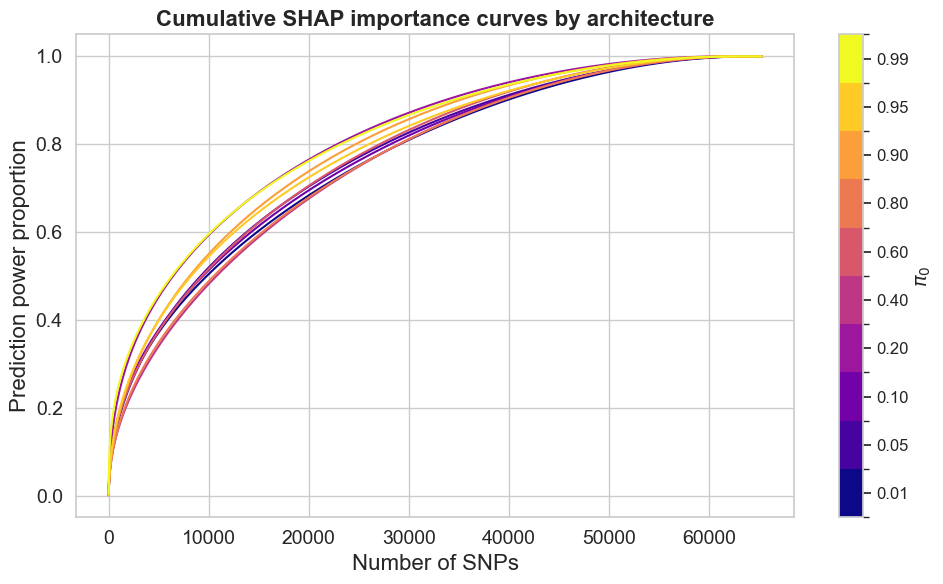

In [3]:
# Architecture and corresponding pi_0 values
arch_values = list(range(1, 11))
pi_0_values = [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create discrete colormap with 10 colors
colors = cm.plasma(np.linspace(0, 1, 10))
cmap = mcolors.ListedColormap(colors)
bounds = np.linspace(0.5, 10.5, 11)  # for 10 bins centered at 1–10
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines
for idx, (arch, pi_0) in enumerate(zip(arch_values, pi_0_values)):
    shap_values = pd.read_feather(f'C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/SHAP/Sim/shap_70k_arch_{arch}.feather')
    deviations = -np.sort(-np.sum(np.abs(shap_values), axis=0))
    deviations /= np.sum(deviations)
    cummulative_deviations = np.cumsum(deviations)
    x = np.linspace(0, len(deviations), len(deviations))
    ax.plot(x, cummulative_deviations, color=cmap(idx), label=f"π₀ = {pi_0}")

# Labels and title
ax.set_xlabel("Number of SNPs", fontsize=16)
ax.set_ylabel("Prediction power proportion", fontsize=16)
ax.set_title("Cumulative SHAP importance curves by architecture", fontsize=16, weight="bold")
ax.tick_params(axis='both', labelsize=14)

# Discrete colorbar
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ticks=range(1, 11), ax=ax)
cbar.ax.set_yticklabels([f"{p:.2f}" for p in pi_0_values])  # Set tick labels as pi_0 values
cbar.set_label(r'$\pi_0$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Save and show
plt.tight_layout()
plt.savefig("C:/Users/gard_/Documents/MasterThesis/Code/Figures/CFI_SHAP_sim.pdf", dpi=300)
plt.show()

# Cumulative feature importance plot

Does the same as the previous section, but with one singel architecture type plotted alone.

In [8]:
shap_values = pd.read_feather('C:/Users/gard_/Documents/MasterThesis/Code/Results/70k/SHAP/Sim/shap_70k_arch_' + arch + '.feather')

In [9]:
# shap_values is (n x p) vector of shapley values
# 1) Take absolute value of all Shapley values
# 2) Sum the Shapley values SHAP_j over all the indvs -> (p x 1) vector created
# 3) Put the accumulated Shapley values in descending order (Highest absolute value first)
deviations = -np.sort(-np.sum(np.abs(shap_values),axis = 0)) # (p x 1)
# Standardize deviations so that they sum to one?
scale = sum(deviations)
deviations = deviations/scale

In [10]:
# Adds contributions to devuation for each SNP, starting with biggest
cummulative_deviations = np.zeros(len(deviations))
temp = 0
for i in range(len(deviations)):
    temp += deviations[i]
    cummulative_deviations[i] = temp

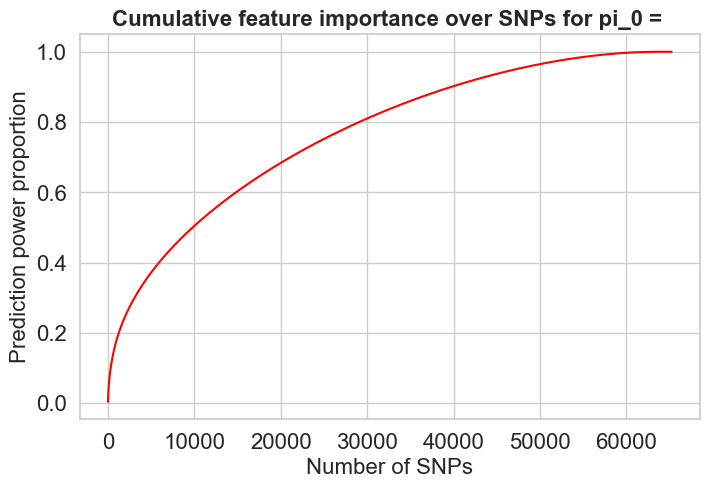

In [11]:
n_subset = len(deviations)
x = np.linspace(0, n_subset, n_subset)
data = pd.DataFrame({
    "Number of SNPs": x,
    "Proportion of deviation": cummulative_deviations[:n_subset]
})

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create line plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=data, x="Number of SNPs", y="Proportion of deviation", color="red")
plt.title("Cumulative feature importance over SNPs for pi_0 = ", fontsize=16, weight="bold")
plt.xlabel("Number of SNPs", fontsize=16)
plt.ylabel("Prediction power proportion", fontsize=16)
plt.tick_params(axis='both', labelsize=16)

plt.savefig("C:/Users/gard_/Documents/MasterThesis/Code/Figures/SHAP_Arch/Arch_" + arch + "_cumulative_deviations.pdf", dpi=300, bbox_inches="tight")
plt.show()